In [1]:
# Config mylib package
import os
from pathlib import Path
import sys
if Path("/kaggle").exists():
    platform = "kaggle"
    sys.path.append("/kaggle/input/new-energy-power-plant-scheduling-problem/")
    os.environ["MYLIB_DATASETS_DIR"] = "/kaggle/input/new-energy-plant/data"
    IMG_DIR = Path("/kaggle/working/imgs/")
    MODEL_DIR = Path("/kaggle/working/model")
else:
    platform = "local"
    os.environ["KERAS_BACKEND"] = "jax"
    os.environ["MYLIB_DATASETS_DIR"] = "../../dataset/data"
    IMG_DIR = Path("../../output/imgs")
    MODEL_DIR = Path("../../output/model")
IMG_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)
from mylib import *
print("mylib version is {mylib.__version__}")
print(f"the platform is {platform}")

mylib version is {mylib.__version__}
the platform is local


In [2]:
# Config other package
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams["font.family"] = "SimSun"
#plt.rcParams["axes.unicode_minus"] = False

set_rcParams(figsize = (30,6))

In [3]:
# Important arguments
plot_kw = dict(show=True, save=True, img_dir=IMG_DIR/"lstm")
# data size
N = 1 * 60 * 60 * 24 # 1 day 
window_pre = 3 * 60 # 1 mins
window_post = 1 # 1 s
test_rate = 0.2
# super arguments
epochs = 1
batch_size = 1024
dropout_rate = 0.2
# train or load
TRAIN = (platform == "kaggle")

In [4]:
# load dataset
dfs = [ load_dataset(ds) for ds in DataSet ]
print(dfs[0].head())

                value
738911257.0  0.569018
738911258.0  0.569091
738911259.0  0.569127
738911260.0  0.568845
738911261.0  0.568736


In [5]:
# LSTM model (fit or load)
import keras
from numpy.lib.stride_tricks import sliding_window_view
from mylib.models.lstm import SimpleLSTMRegression

def get_models_and_data(dfs, train=True):
    models = []
    X_trains, X_tests, y_trains, y_tests = [],[],[],[]

    for ds, df in zip(DataSet, dfs):
        ts = df.iloc[-N:,0]
        data = sliding_window_view(ts, window_shape=window_post + window_pre)
        X, y = data[:,:window_pre], data[:,window_pre:]
        X = X.reshape((X.shape[0],window_pre,-1))
        test_size = int(X.shape[0]*(1-test_rate))
        X_train, X_test = X[:test_size],X[test_size:]
        y_train, y_test = y[:test_size],y[test_size:]

        X_trains.append(X_train)
        X_tests.append(X_test)
        y_trains.append(y_train)
        y_tests.append(y_test)
        if not train:
            lstm = keras.saving.load_model(MODEL_DIR / f"{ds.name}-lstm-regression.keras")
            models.append(lstm)
            print(f"{lstm.name} is loaded.")
            continue
        lstm = SimpleLSTMRegression(
            input_shape=X.shape[1:],
            units=128,
            window_post=window_post,
            dropout_rate=dropout_rate,
            name=f"{ds.name}-lstm-regression"
        )
        #lstm.summary()
        lstm.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.MeanSquaredError(),
        )
        models.append(lstm)
        print(f"{lstm.name} model compile over.")
    if train:
        # fit models
        histories = []
        for model,X_train,y_train in zip(models,X_trains, y_trains):
            history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)
            histories.append(history)
            print(f"{model.name} model fitted over.")
        # save models
        for model in models:
            model.save(MODEL_DIR / f"{model.name}.keras")
    return models, X_trains, X_tests, y_trains, y_tests
models, X_trains, X_tests, y_trains, y_tests = get_models_and_data(dfs,train=TRAIN)

Solar-lstm-regression is loaded.
WindPower-lstm-regression is loaded.
WindVelocity-lstm-regression is loaded.


539/539 ━━━━━━━━━━━━━━━━━━━━ 60s 112ms/step


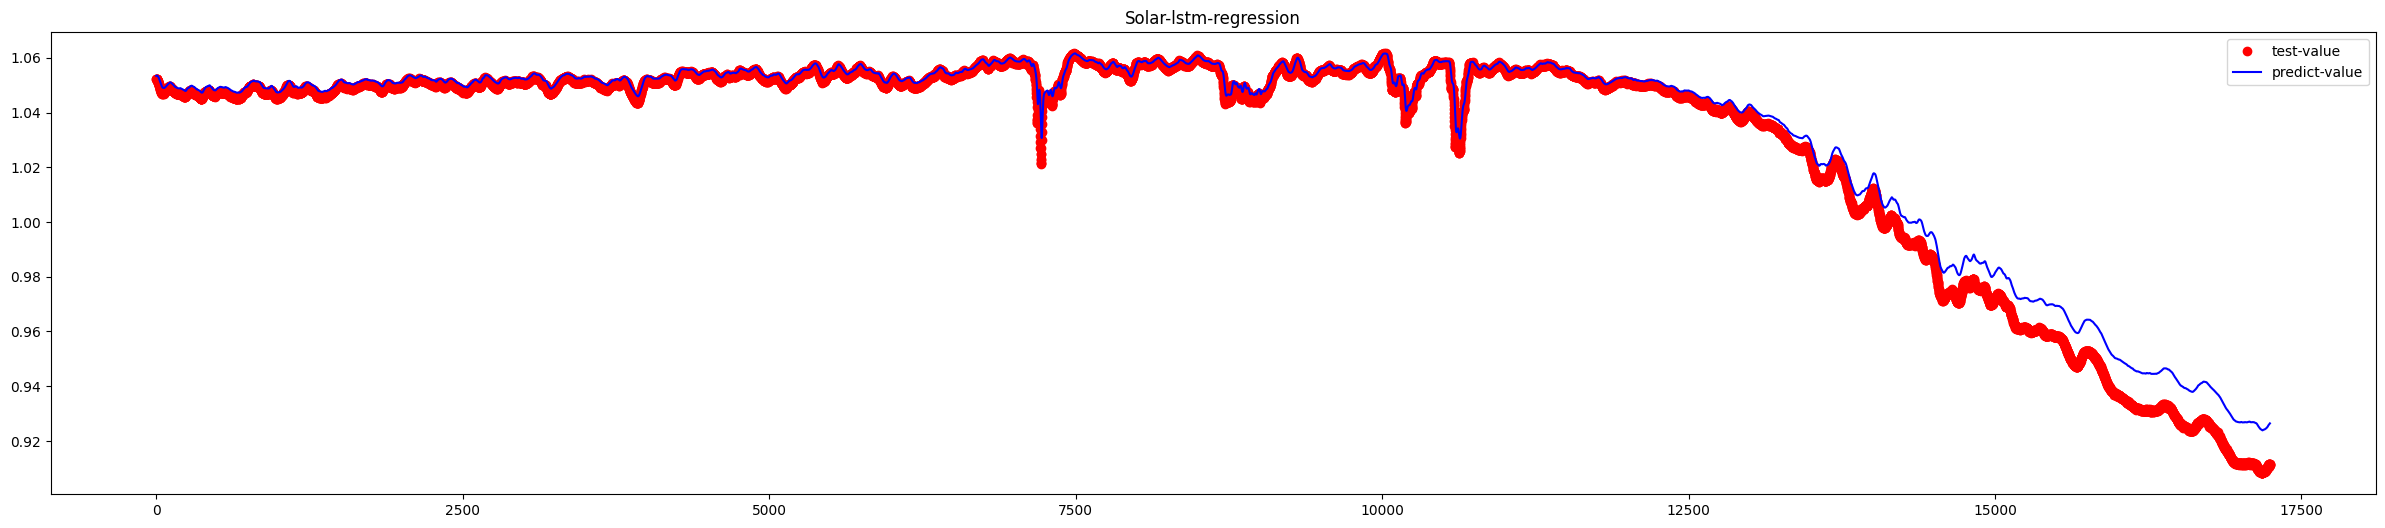

539/539 ━━━━━━━━━━━━━━━━━━━━ 62s 115ms/step


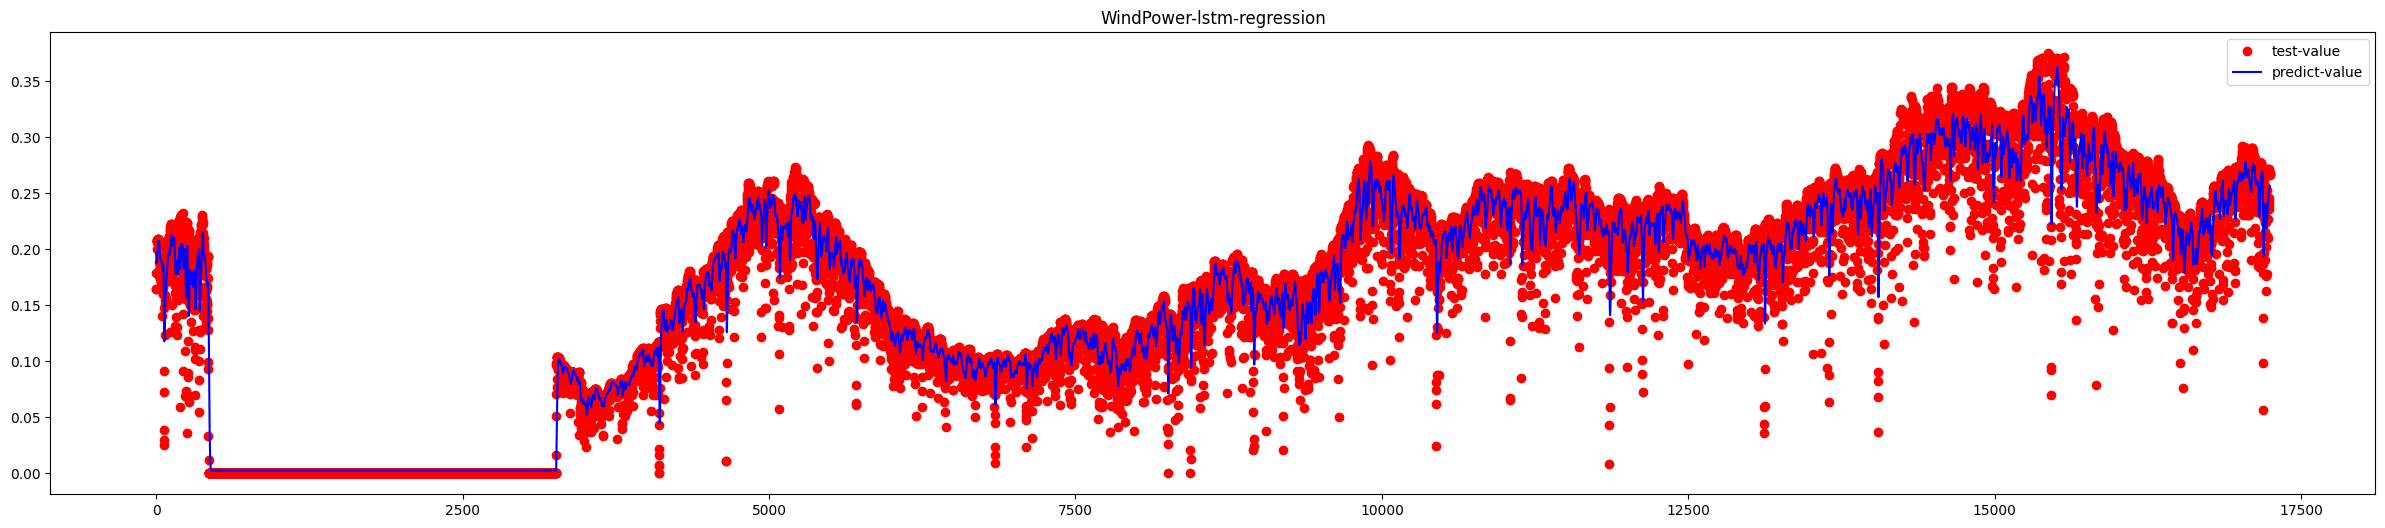

539/539 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step


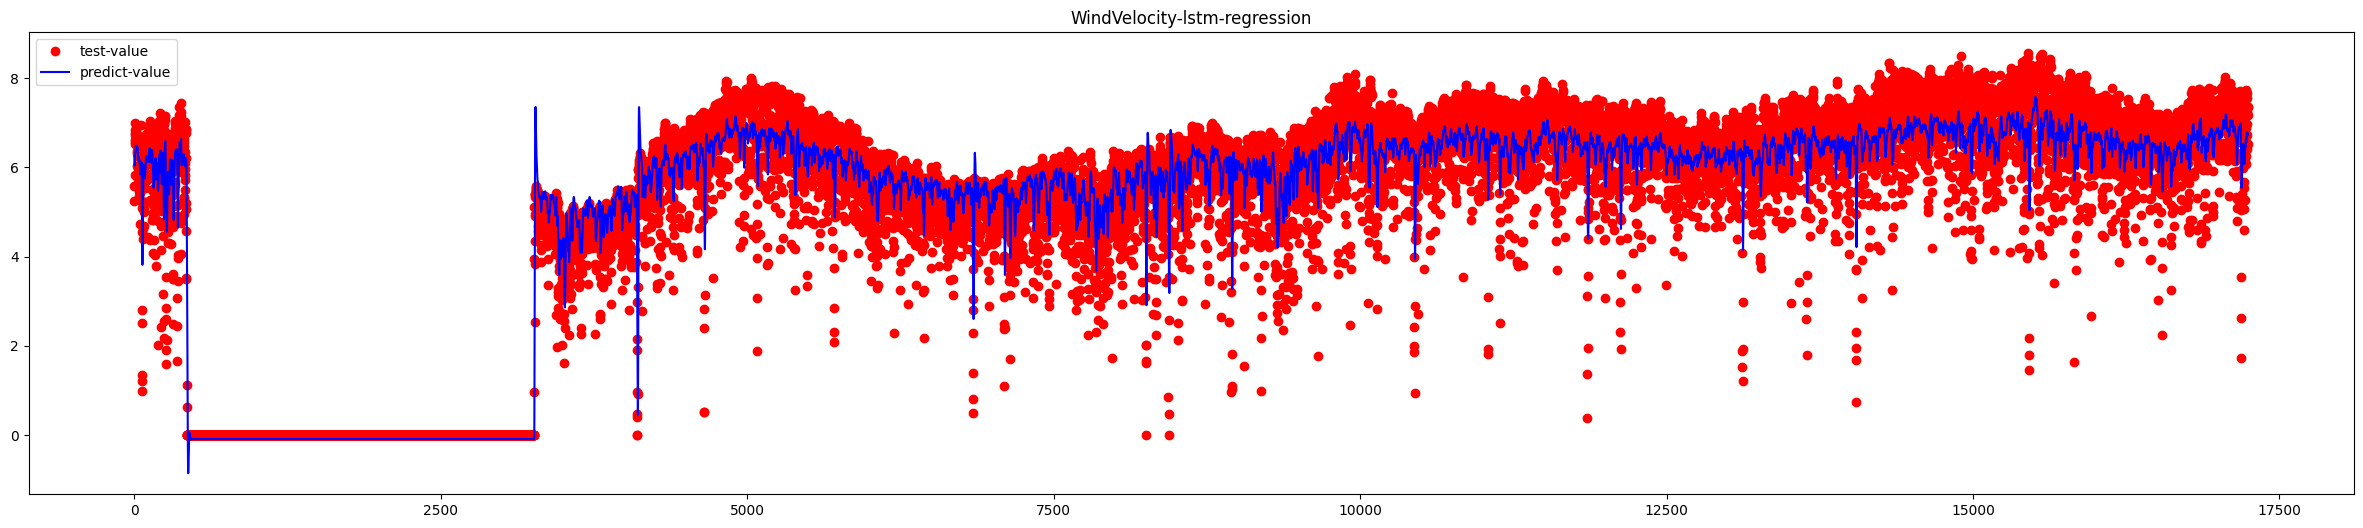

In [ ]:
# plot results
#plot_n = 1024
test_losses = []
for model,X_test,y_test in zip(models,X_tests,y_tests):
    #y_test = y_test[-plot_n:]
    #X_test = X_test[-plot_n:]
    y_pred = model.predict(X_test)
    plt.plot(y_test.reshape((-1,)),'ro',label="test-value")
    plt.plot(y_pred.reshape((-1,)),'b-',label="predict-value")
    plt.legend()
    plt.title(model.name)
    post_plot(**plot_kw)

In [8]:
# test losses
#n_test = 1024
test_losses = []
for model,X_test,y_test in zip(models,X_tests,y_tests):
    #X_test, y_test = X_test[-n_test:],y_test[-n_test:]
    test_loss = model.evaluate(X_test,y_test)
    print(f"Mean square error on the test set: {test_loss}")
    test_losses.append(test_loss)

539/539 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - loss: 5.3505e-06
Mean square error on the test set: 3.089625170105137e-05
539/539 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - loss: 4.0656e-04
Mean square error on the test set: 0.000564973393920809
539/539 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - loss: 0.4550
Mean square error on the test set: 0.5262393951416016
